# 03 - Time Delta Validation

## Imports

In [1]:
import avn.segmentation as segmentation
import pandas as pd
import numpy as np
import avn.dataloading as dataloading
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_match_times(truth_matches, seg_current_file):

    #initialize empty 1D array to contain timestamps
    matched_times = np.zeros_like(truth_matches)

    #loop through each match and add timestamp to matched_times
    for i, match_idx in enumerate(truth_matches):
        #if the match_idx is nan, that means the true syll had no match, so record nan as timestamp
        if np.isnan(match_idx):
            matched_times[i] = np.nan
        else: 
            matched_times[i] = seg_current_file.onsets.iloc[int(match_idx)]

    return matched_times

In [3]:
def get_time_delta_df(seg_data, max_gap = 0.05, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [4]:
def get_time_deltas_many_birds(segmenter, Bird_IDs, folder_path, upper_threshold, lower_threshold, truth_table_suffix = "_syll_table.csv", 
                               max_gap = 0.05, feature = 'onsets'):

    #initialize empty dataframe to append to
    all_time_deltas_df = pd.DataFrame()

    #loop through each bird
    for Bird_ID in Bird_IDs: 
        #construct full path to folder containing song files
        song_folder = folder_path + Bird_ID + "/"

        #make segmentations
        seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                     upper_threshold = upper_threshold, 
                                                     lower_threshold = lower_threshold)

        #load ground truth segmentations from memory
        seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, song_folder + Bird_ID + truth_table_suffix)

        #get time delta table for current bird
        curr_time_delta_df = get_time_delta_df(seg_data, max_gap = max_gap, feature = feature)
        #add Bird_ID to current df
        curr_time_delta_df['Bird_ID'] = Bird_ID
        #append to df with all birds
        all_time_deltas_df = pd.concat([all_time_deltas_df, curr_time_delta_df])

    #add column with time deltas
    all_time_deltas_df['time_delta'] = all_time_deltas_df.True_feat_times - all_time_deltas_df.seg_matched_times

    return all_time_deltas_df

In [5]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [6]:
dataloading.SongFile = SongFile

# Onsets

## Get Time Deltas 

In [18]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

### RMSE

In [19]:
song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"
segmenter = segmentation.RMSEDerivative()

In [20]:
all_time_deltas_RMSE = get_time_deltas_many_birds(segmenter, All_Birds, song_folder, 
                                                upper_threshold = 0.006, lower_threshold= -0.1, max_gap = 0.01)

### TweetyNet

In [21]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [22]:
#initialize df with all birds' time deltas. 
all_time_deltas_Tweety = pd.DataFrame()

for Bird_ID in All_Birds: 

    #load tweetynet segmentation table
    predictions_path =  'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/April_redo_data/vak_segmentation/segmented_songs_annotations/' + Bird_ID + '.annot.csv'
    predictions_vak = pd.read_csv(predictions_path)
    predictions_reformat = vak_to_syll_table(predictions_vak)

    #load ground truth
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions_reformat)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets')
    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_Tweety = pd.concat([all_time_deltas_Tweety, curr_bird_time_delta])

#add time delta column 
all_time_deltas_Tweety['time_delta'] = all_time_deltas_Tweety.True_feat_times - all_time_deltas_Tweety.seg_matched_times

### Wseg

In [23]:
def get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [24]:
#initialize df with all birds' time deltas. 
all_time_deltas_wseg = pd.DataFrame()

for Bird_ID in All_Birds[:]: 

    #load tweetynet segmentation table
    predictions_path =  'E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + '_wseg.csv'
    predictions = pd.read_csv(predictions_path)
    predictions = predictions.drop(columns = ['Unnamed: 0', 'cluster'])
    predictions = predictions.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

    #load ground truth
    ground_truth_path = 'E:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets')

    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_wseg = pd.concat([all_time_deltas_wseg, curr_bird_time_delta])

#add time delta column 
all_time_deltas_wseg['time_delta'] = all_time_deltas_wseg.True_feat_times - all_time_deltas_wseg.seg_matched_times

## Merge Time Deltas

In [25]:
all_time_deltas_Tweety['Segmentation Method'] = "TweetyNet"
all_time_deltas_RMSE['Segmentation Method'] = "Amplitude Threshold" 
all_time_deltas_wseg['Segmentation Method'] = "WhisperSeg"

In [26]:
all_time_deltas = pd.concat([all_time_deltas_Tweety, all_time_deltas_RMSE, all_time_deltas_wseg])

In [27]:
plt.rcParams.update({'font.size': 11})

In [34]:
all_time_deltas['time_delta'] = all_time_deltas.time_delta * 1000

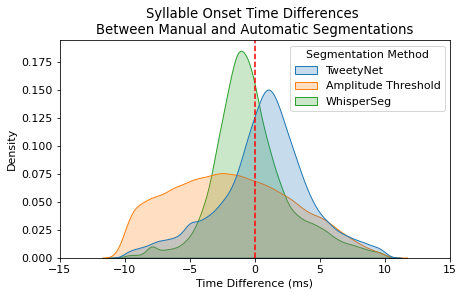

In [42]:
plt.figure(figsize = (7, 4))
sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True)
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.xlim(-15, 15)
plt.xlabel("Time Difference (ms)")
plt.title("Syllable Onset Time Differences \nBetween Manual and Automatic Segmentations");

In [38]:
all_time_deltas['abs_delta'] = np.abs(all_time_deltas.time_delta)

In [39]:
all_time_deltas.groupby('Segmentation Method').mean()

,True_feat_times,index_of_match,seg_matched_times,time_delta,abs_delta
Segmentation Method,,,,,
Amplitude Threshold,6.152806,27.382374,6.105347,-1.768328,4.140926
TweetyNet,6.152806,22.169655,6.100720,0.651469,2.790156
WhisperSeg,6.154528,17.801169,5.757466,-0.281058,2.271382


In [40]:
from scipy.stats import sem
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'WhisperSeg'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'TweetyNet'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'Amplitude Threshold'].abs_delta, nan_policy= 'omit'))

0.010061502372474673
0.011504749266966539
0.014963278345235398


# Offsets

In [59]:
def get_match_times(truth_matches, seg_current_file):

    #initialize empty 1D array to contain timestamps
    matched_times = np.zeros_like(truth_matches)

    #loop through each match and add timestamp to matched_times
    for i, match_idx in enumerate(truth_matches):
        #if the match_idx is nan, that means the true syll had no match, so record nan as timestamp
        if np.isnan(match_idx):
            matched_times[i] = np.nan
        else: 
            matched_times[i] = seg_current_file.offsets.iloc[int(match_idx)]

    return matched_times

## Get Time Deltas 

In [60]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

### RMSE

In [61]:
song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"
segmenter = segmentation.RMSEDerivative()

In [62]:
all_time_deltas_RMSE = get_time_deltas_many_birds(segmenter, All_Birds, song_folder, 
                                                upper_threshold = 0.006, lower_threshold= -0.1, max_gap = 0.05, feature = 'offsets')

### TweetyNet

In [63]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [64]:
#initialize df with all birds' time deltas. 
all_time_deltas_Tweety = pd.DataFrame()

for Bird_ID in All_Birds: 

    #load tweetynet segmentation table
    predictions_path =  'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/April_redo_data/vak_segmentation/segmented_songs_annotations/' + Bird_ID + '.annot.csv'
    predictions_vak = pd.read_csv(predictions_path)
    predictions_reformat = vak_to_syll_table(predictions_vak)

    #load ground truth
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions_reformat)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.05, feature = 'offsets')
    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_Tweety = pd.concat([all_time_deltas_Tweety, curr_bird_time_delta])

#add time delta column 
all_time_deltas_Tweety['time_delta'] = all_time_deltas_Tweety.True_feat_times - all_time_deltas_Tweety.seg_matched_times

### Wseg

In [65]:
#initialize df with all birds' time deltas. 
all_time_deltas_wseg = pd.DataFrame()

for Bird_ID in All_Birds[:]: 

    #load tweetynet segmentation table
    predictions_path =  'E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + '_wseg.csv'
    predictions = pd.read_csv(predictions_path)
    predictions = predictions.drop(columns = ['Unnamed: 0', 'cluster'])
    predictions = predictions.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

    #load ground truth
    ground_truth_path = 'E:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.05, feature = 'offsets')

    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_wseg = pd.concat([all_time_deltas_wseg, curr_bird_time_delta])

#add time delta column 
all_time_deltas_wseg['time_delta'] = all_time_deltas_wseg.True_feat_times - all_time_deltas_wseg.seg_matched_times

## Merge Time Deltas

In [66]:
all_time_deltas_Tweety['Segmentation Method'] = "TweetyNet"
all_time_deltas_RMSE['Segmentation Method'] = "Amplitude Threshold" 
all_time_deltas_wseg['Segmentation Method'] = "WhisperSeg"

In [67]:
all_time_deltas = pd.concat([all_time_deltas_Tweety, all_time_deltas_RMSE, all_time_deltas_wseg])

In [68]:
all_time_deltas['time_delta'] = all_time_deltas.time_delta * 1000

In [69]:
plt.rcParams.update({'font.size': 11})

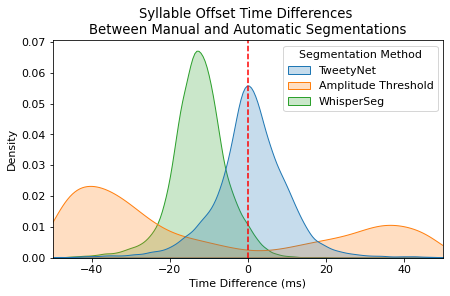

In [76]:
plt.figure(figsize = (7, 4))
sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True)
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.xlim(-50, 50)
plt.xlabel("Time Difference (ms)")
plt.title("Syllable Offset Time Differences \nBetween Manual and Automatic Segmentations");

In [72]:
all_time_deltas['abs_delta'] = np.abs(all_time_deltas.time_delta)

In [74]:
all_time_deltas.groupby('Segmentation Method').mean()

,True_feat_times,index_of_match,seg_matched_times,time_delta,abs_delta
Segmentation Method,,,,,
Amplitude Threshold,6.254579,28.736407,6.022939,-12.105330,32.583166
TweetyNet,6.254579,22.067945,6.170419,0.613248,7.324591
WhisperSeg,6.256277,17.735438,5.910703,-12.622435,12.963650


In [75]:
from scipy.stats import sem
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'WhisperSeg'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'TweetyNet'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'Amplitude Threshold'].abs_delta, nan_policy= 'omit'))

0.03409458310495717
0.0352863088071408
0.06962750872126879
